Подключение библиотек

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import callbacks
from keras import backend as K
from sklearn.metrics import roc_curve, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


Функции для нахождения Recall, Precision и F1

In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Загружаем датасет

In [5]:
data_row = pd.read_csv("./movies_num")
# data = data_row.drop(columns=["original_language"])
data = data_row
# Low_Popular = lp = 0, Medium_Popular = mp = 1, High Popular = hp = 2
data["popularity"] = pd.cut(x=data['popularity'], bins=[0, 10, 30, 1000], labels=['lp', 'mp', 'hp'])
data = data.dropna()
data = data.drop(data[(data.budget == 0) | (data.revenue == 0) | (data.runtime == 0) | (data.popularity == 0)].index)
data

,budget,popularity,revenue,runtime,vote_average,vote_count
0,237000000,hp,2787965087,162.0,7.2,11800
1,300000000,hp,961000000,169.0,6.9,4500
2,245000000,hp,880674609,148.0,6.3,4466
3,250000000,hp,1084939099,165.0,7.6,9106
4,260000000,hp,284139100,132.0,6.1,2124
...,...,...,...,...,...,...
4773,27000,mp,3151130,92.0,7.4,755
4788,12000,lp,6000000,93.0,6.2,110
4792,20000,lp,99000,111.0,7.4,63
4796,7000,mp,424760,77.0,6.9,658


In [6]:
data.groupby(['popularity']).count()

,budget,revenue,runtime,vote_average,vote_count
popularity,,,,,
lp,769,769,769,769,769
mp,1373,1373,1373,1373,1373
hp,1087,1087,1087,1087,1087


Бинаризируем классы

In [7]:
num_data = pd.get_dummies(data)
num_data.head()

,budget,revenue,runtime,vote_average,vote_count,popularity_lp,popularity_mp,popularity_hp
0,237000000,2787965087,162.0,7.2,11800,0,0,1
1,300000000,961000000,169.0,6.9,4500,0,0,1
2,245000000,880674609,148.0,6.3,4466,0,0,1
3,250000000,1084939099,165.0,7.6,9106,0,0,1
4,260000000,284139100,132.0,6.1,2124,0,0,1


Нормализуем данные

In [8]:
mm_scalar = preprocessing.MinMaxScaler()
mm_scalar.fit(num_data)
norm_data_row = pd.DataFrame(columns=num_data.columns, data=mm_scalar.transform(num_data))
norm_data = norm_data_row.rename(columns={"popularity_lp": 0, "popularity_mp": 1, "popularity_hp": 2})
norm_data

,budget,revenue,runtime,vote_average,vote_count,0,1,2
0,0.623684,1.000000,0.407407,0.847059,0.858057,0.0,0.0,1.0
1,0.789474,0.344696,0.430976,0.811765,0.327225,0.0,0.0,1.0
2,0.644737,0.315884,0.360269,0.741176,0.324753,0.0,0.0,1.0
3,0.657895,0.389151,0.417508,0.894118,0.662158,0.0,0.0,1.0
4,0.684211,0.101916,0.306397,0.717647,0.154450,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
3224,0.000071,0.001130,0.171717,0.870588,0.054901,0.0,1.0,0.0
3225,0.000032,0.002152,0.175084,0.729412,0.007999,1.0,0.0,0.0
3226,0.000053,0.000036,0.235690,0.870588,0.004581,1.0,0.0,0.0
3227,0.000018,0.000152,0.121212,0.811765,0.047848,0.0,1.0,0.0


Делим данные на тренировочную и тестовую выборку

In [9]:
X = norm_data[norm_data.columns[:5]]
Y = norm_data[norm_data.columns[5:]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
Y_test

,0,1,2
19,0.0,0.0,1.0
2842,0.0,1.0,0.0
2571,1.0,0.0,0.0
346,0.0,0.0,1.0
335,1.0,0.0,0.0
...,...,...,...
550,0.0,0.0,1.0
1724,0.0,1.0,0.0
2840,1.0,0.0,0.0
2922,0.0,1.0,0.0


Создаем нейронную сеть

In [10]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(20, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.sigmoid))
    model.compile(Adam(), categorical_crossentropy, metrics=['acc', f1_m, precision_m, recall_m])
    return model

model = make_nn(X_train.shape[1], Y_train.shape[1])

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=5,
    epochs=150,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History() 
    ]
    
)

Epoch 1/150
517/517 - 1s - loss: 1.0131 - acc: 0.5130 - f1_m: 0.2173 - precision_m: 0.3988 - recall_m: 0.1629 - val_loss: 0.9342 - val_acc: 0.6223 - val_f1_m: 0.2294 - val_precision_m: 0.5385 - val_recall_m: 0.1523 - 1s/epoch - 2ms/step
Epoch 2/150
517/517 - 0s - loss: 0.8747 - acc: 0.6012 - f1_m: 0.4056 - precision_m: 0.5752 - recall_m: 0.3338 - val_loss: 0.8085 - val_acc: 0.6378 - val_f1_m: 0.4757 - val_precision_m: 0.6331 - val_recall_m: 0.4000 - 376ms/epoch - 727us/step
Epoch 3/150
517/517 - 0s - loss: 0.7795 - acc: 0.6245 - f1_m: 0.4919 - precision_m: 0.6197 - recall_m: 0.4297 - val_loss: 0.7356 - val_acc: 0.6486 - val_f1_m: 0.4959 - val_precision_m: 0.6500 - val_recall_m: 0.4262 - 373ms/epoch - 721us/step
Epoch 4/150
517/517 - 0s - loss: 0.7210 - acc: 0.6504 - f1_m: 0.5576 - precision_m: 0.6539 - recall_m: 0.5105 - val_loss: 0.6908 - val_acc: 0.7276 - val_f1_m: 0.6398 - val_precision_m: 0.7196 - val_recall_m: 0.6092 - 366ms/epoch - 708us/step
Epoch 5/150
517/517 - 0s - loss: 0.67

Выводим графики ошибки и точности

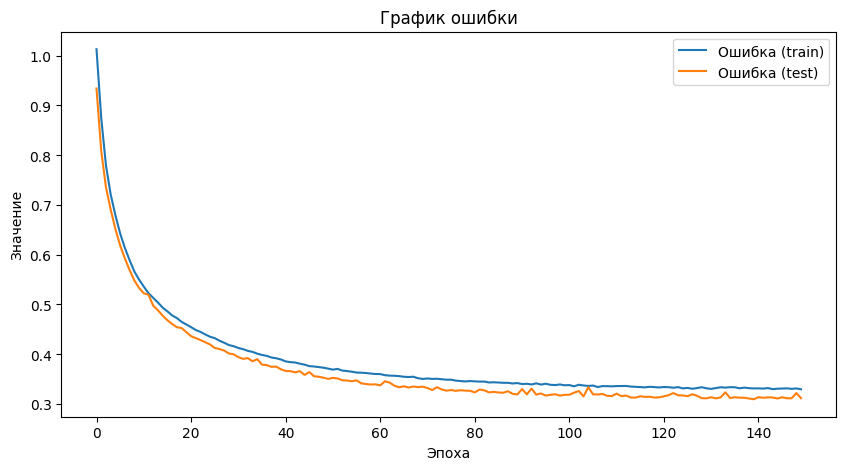

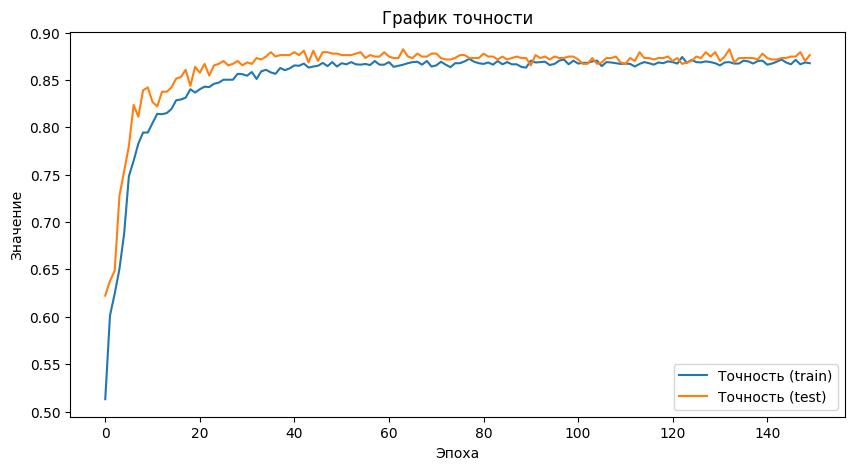

In [11]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)'])

Вывод метрик

In [12]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Loss: 0.31153908371925354
Accuracy: 0.8761609792709351
F1: 0.8654187321662903
Precision: 0.8486894965171814
Recall: 0.8849206566810608


Сравнение правильного ответа и предсказанного

In [13]:
Y_test = Y_test.reset_index(drop=True)
predicted_row = pd.DataFrame(model.predict(X_test))
predicted = pd.DataFrame(model.predict(X_test).argmax(axis=1), columns=['predicted'])
# predicted = predicted_multilabel.replace([0, 1, 2], ["Bad", "Medium", "Good"])
predicted["real"] = pd.DataFrame(Y_test.idxmax(axis=1).values)
predicted


21/21 [==============================] - 0s 499us/step


,predicted,real
0,2,2
1,1,1
2,0,0
3,2,2
4,0,0
...,...,...
641,2,2
642,1,1
643,1,0
644,1,1


In [14]:
predicted_row

,0,1,2
0,0.153794,0.071106,8.829916e-01
1,0.018840,0.730446,7.870834e-02
2,0.724360,0.144397,3.119029e-11
3,0.095089,0.082438,8.997267e-01
4,0.503308,0.337154,5.487121e-08
...,...,...,...
641,0.104316,0.043803,9.206241e-01
642,0.051938,0.715945,1.116514e-03
643,0.395346,0.422640,2.080901e-08
644,0.033424,0.610026,4.825714e-01


In [15]:
predicted_bool = (predicted_row.T == predicted_row.max(axis=1)).T.astype(int)
predicted_bool

,0,1,2
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
...,...,...,...
641,0,0,1
642,0,1,0
643,0,1,0
644,0,1,0


Вывод ROC кривых для каждой категории

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


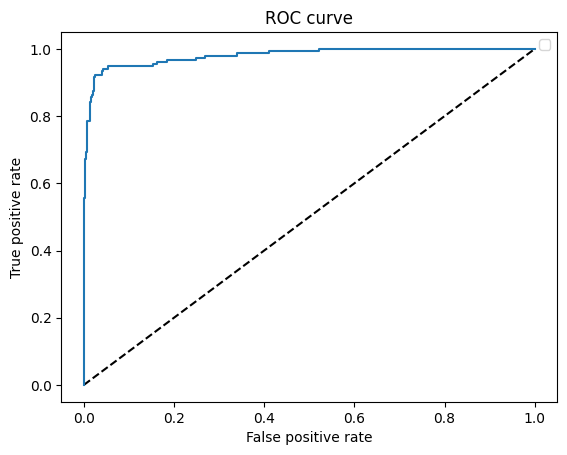

In [16]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[0].values, predicted_row[0].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


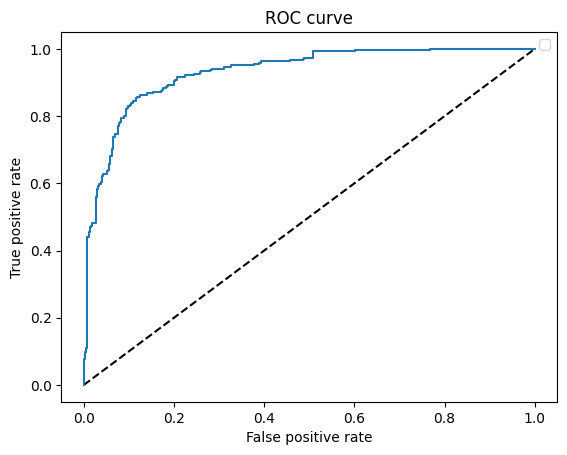

In [17]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[1].values, predicted_row[1].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


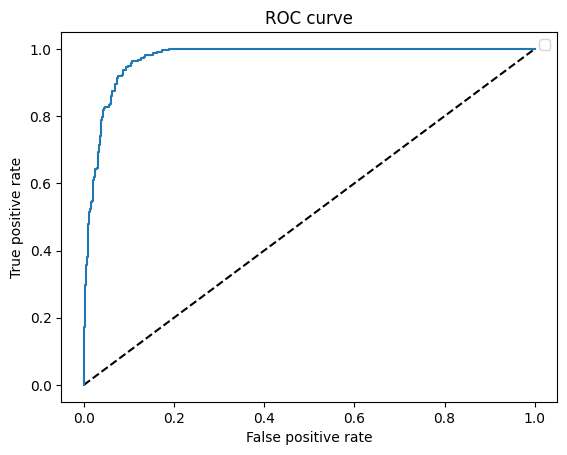

In [18]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[2].values, predicted_row[2].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Вывод матриц ошибок для каждого класса

Text(0.5, 23.52222222222222, 'Prediction')

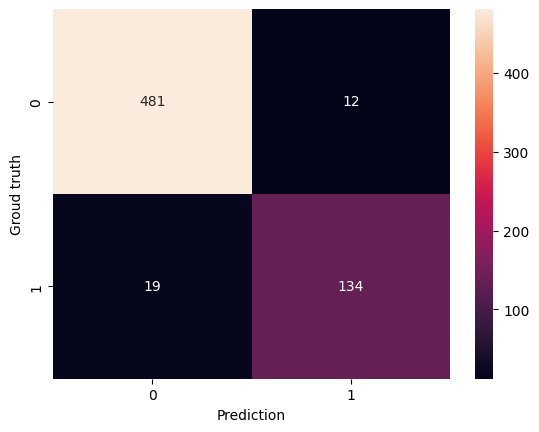

In [19]:
cm = confusion_matrix(Y_test[0], predicted_bool[0])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

Text(0.5, 23.52222222222222, 'Prediction')

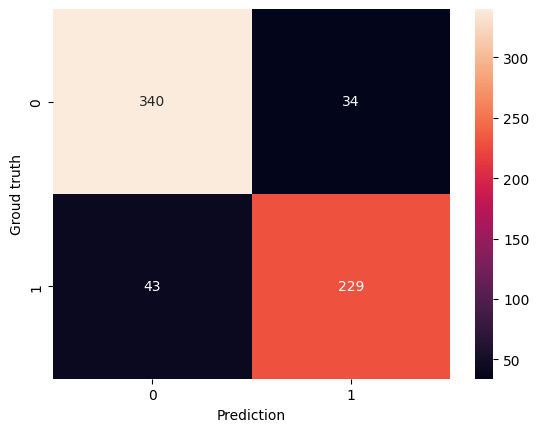

In [20]:
cm = confusion_matrix(Y_test[1], predicted_bool[1])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

Text(0.5, 23.52222222222222, 'Prediction')

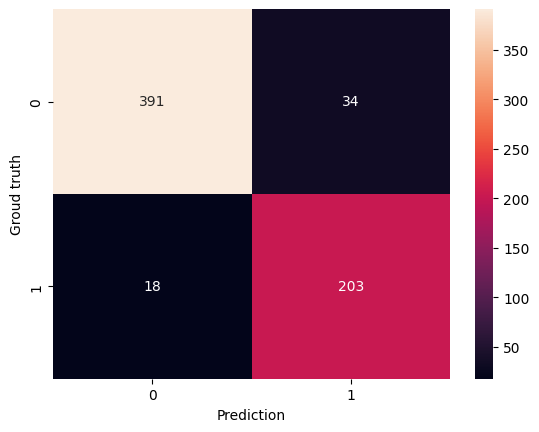

In [21]:
cm = confusion_matrix(Y_test[2], predicted_bool[2])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

Проекция признаков на двухмерную ось

In [22]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
target_names = {
    0:'lp',
    1:'mp', 
    2:'hp'
}
pca_df['target'] = pd.DataFrame(Y.values.argmax(axis=1))
pca_df['target'] = pca_df['target'].map(target_names)

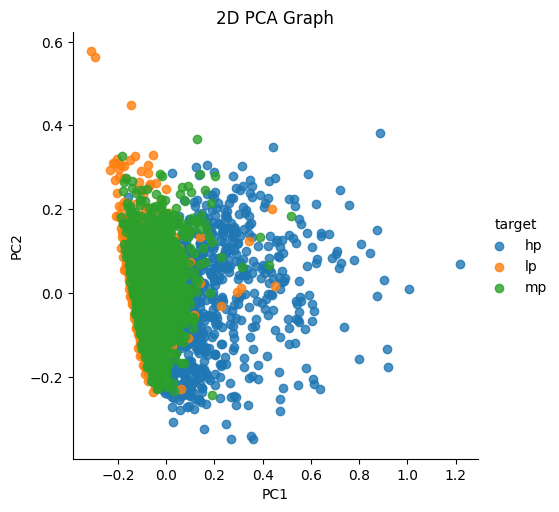

In [23]:
sb.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True
    )
plt.title('2D PCA Graph')
plt.show()

In [24]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(3229, 2)
814/814 [==============================] - 0s 466us/step


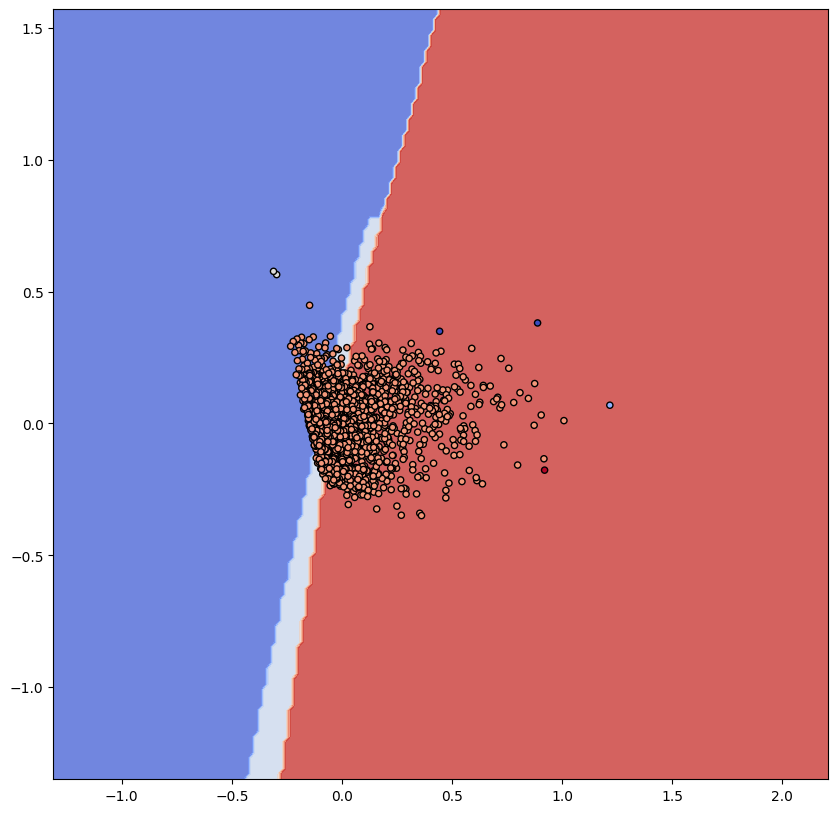

In [25]:
from sklearn.decomposition import PCA

model_clf = model

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model_clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])).argmax(axis=1)

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=X.apply(lambda x: x.argmax(), axis=1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')